In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/drive/MyDrive/DEV/PROJECT/201608.csv')

In [4]:
sel_df = df[['fullVisitorId','visitId','visitNumber','date','hitNumber','action_type','step','pagePath','pageTitle']]

In [5]:
# 세션을 하나로 묶기
session_group = sel_df.groupby(['fullVisitorId', 'visitId', 'visitNumber', 'date'])

# 각 세션에서 action_type이 최대인 행만 추출
max_action_df = session_group.apply(lambda x: x.loc[x['action_type'].idxmax()][['action_type', 'step']])

# 인덱스를 정리 (MultiIndex → 일반 컬럼)
max_action_df = max_action_df.reset_index()

# df 이름 변경
df1 = max_action_df

# 결과 확인
df1.head()

<ipython-input-5-0c9778ee28d8>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_action_df = session_group.apply(lambda x: x.loc[x['action_type'].idxmax()][['action_type', 'step']])


,fullVisitorId,visitId,visitNumber,date,action_type,step
0,5103959234087,1471817208,1,20160821,2,1
1,75746323734481,1470830877,1,20160810,0,1
2,90134415725564,1471724127,1,20160820,0,1
3,97118899221776,1471583038,1,20160818,0,1
4,101322961649621,1470315915,1,20160804,0,1


In [35]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74759 entries, 0 to 74758
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   fullVisitorId      74759 non-null  uint64  
 1   visitId            74759 non-null  int64   
 2   visitNumber        74759 non-null  int64   
 3   date               74759 non-null  int64   
 4   action_type        74759 non-null  int64   
 5   step               74759 non-null  int64   
 6   sessionId          74759 non-null  int64   
 7   action_type_level  74759 non-null  category
 8   action_group       74759 non-null  int64   
 9   session_key        74759 non-null  object  
dtypes: category(1), int64(7), object(1), uint64(1)
memory usage: 5.2+ MB


In [6]:
# 기준 컬럼으로 고유한 세션 정의
df1['sessionId'] = df1.groupby(
    ['fullVisitorId', 'visitId', 'visitNumber', 'date']
).ngroup()

# 중복 확인: sessionId 개수와 고유 세션 수 비교
num_unique_sessions = df1[['fullVisitorId', 'visitId', 'visitNumber', 'date']].drop_duplicates().shape[0]
num_unique_sessionIds = df1['sessionId'].nunique()

print(f"고유 세션 수: {num_unique_sessions}")
print(f"sessionId 수: {num_unique_sessionIds}")

고유 세션 수: 74759
sessionId 수: 74759


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74759 entries, 0 to 74758
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   fullVisitorId      74759 non-null  uint64  
 1   visitId            74759 non-null  int64   
 2   visitNumber        74759 non-null  int64   
 3   date               74759 non-null  int64   
 4   action_type        74759 non-null  int64   
 5   step               74759 non-null  int64   
 6   sessionId          74759 non-null  int64   
 7   action_type_level  74759 non-null  category
 8   action_group       74759 non-null  int64   
dtypes: category(1), int64(7), uint64(1)
memory usage: 4.6 MB


In [ ]:
print(df1['action_type'].unique())
print(df['step'].unique())

[2 0 4 3 5 6 1]
[1 3 2]


In [7]:
# 레벨 정의 (낮은 → 높은 순)
levels = [0, 1, 2, 3, 4, 5, 6]

# action_type을 범주형으로 변환하면서 순서 지정
df1['action_type_level'] = pd.Categorical(df1['action_type'], categories=levels, ordered=True)

In [ ]:
df['action_type'].value_counts()

,count
action_type,
0,4070803
1,64590
2,53621
5,38129
3,15859
6,8422
4,1911


In [8]:
# 조건 정의
conditions = [
    (df1['action_type'] == 0),
    (df1['action_type'].isin([1, 2])),
    (df1['action_type'].isin([3, 4])),
    (df1['action_type'] == 5) & (df1['step'] == 1),
    (df1['action_type'] == 5) & (df1['step'] == 2),
    (df1['action_type'] == 5) & (df1['step'] == 3),
    (df1['action_type'] == 6)
]

# 대응되는 그룹 값
group_values = [0, 1,2, 3, 4, 5, 6]

# 새로운 그룹 컬럼 생성
df1['action_group'] = np.select(conditions, group_values, default=-1)

In [9]:
df1['action_group'].value_counts().sort_index()
# 결제 단계보다 결제완료의 수가 높음
# -> 가설 , 장바구니 없이 결제까지 바로 이루어지는 세션들이 존재 할 것이다.

,count
action_group,
0,60179
1,8945
2,3467
3,443
4,494
5,86
6,1145


In [10]:
# 가설 검증 :  결제 3단계 중 3번째의 과정은 결제와 상관 없을 것이다.
# 확인 방법 : action_type에서 5는 없지만 6은 있는 세션을 확인하여 결제 과정에서 5번이 필요 없음을 확인


# 세션 키 생성
df1['session_key'] = df1['fullVisitorId'].astype(str) + '_' + df1['visitId'].astype(str) + '_' + df1['date'].astype(str)

# 세션별 action_group 목록
session_action = df1.groupby('session_key')['action_group'].agg(list).reset_index()

# 조건: action_group에 5는 없고, 6은 있는 세션
filtered_sessions = session_action[
    (~session_action['action_group'].apply(lambda x: 5 in x)) &
    (session_action['action_group'].apply(lambda x: 6 in x))
]

# 해당 session_key의 원본 데이터 추출
df_filtered = df1[df1['session_key'].isin(filtered_sessions['session_key'])]

In [17]:
df_filtered.head(20)

,fullVisitorId,visitId,visitNumber,date,action_type,step,sessionId,action_type_level,action_group,session_key
86,2838359588704338,1470663293,1,20160808,6,1,86,6,6,2838359588704338_1470663293_20160808
92,2871498069867123,1471964108,5,20160823,6,1,92,6,6,2871498069867123_1471964108_20160823
151,4868452367846670,1471311136,2,20160815,6,1,151,6,6,4868452367846670_1471311136_20160815
183,5791622267997002,1472681820,2,20160831,6,1,183,6,6,5791622267997002_1472681820_20160831
198,6173812362189693,1472000702,6,20160823,6,1,198,6,6,6173812362189693_1472000702_20160823
200,6173812362189693,1472130704,8,20160825,6,1,200,6,6,6173812362189693_1472130704_20160825
252,8569875679640708,1472022206,1,20160824,6,1,252,6,6,8569875679640708_1472022206_20160824
388,13937734216012052,1472524792,3,20160829,6,1,388,6,6,13937734216012052_1472524792_20160829
527,20153652546549774,1471532396,7,20160818,6,1,527,6,6,20153652546549774_1471532396_20160818
639,25383618704224288,1471894881,2,20160822,6,1,639,6,6,25383618704224288_1471894881_20160822


In [28]:
without_df = df[(df['fullVisitorId']== 6173812362189693) & (df['date']==20160826)]

In [29]:
without_df.to_excel("/content/drive/MyDrive/DEV/PROJECT/without_df.xlsx", index=False)

In [29]:
id_df= df[df['fullVisitorId']== 2591135526102361]

In [30]:
id_df.to_excel("/content/drive/MyDrive/DEV/PROJECT/id_df.xlsx", index=False)

In [18]:
df1[df1['fullVisitorId']== 20153652546549774]

,fullVisitorId,visitId,visitNumber,date,action_type,step,sessionId,action_type_level,action_group,session_key
525,20153652546549774,1470937579,5,20160811,4,1,525,4,2,20153652546549774_1470937579_20160811
526,20153652546549774,1471529072,6,20160818,3,1,526,3,2,20153652546549774_1471529072_20160818
527,20153652546549774,1471532396,7,20160818,6,1,527,6,6,20153652546549774_1471532396_20160818


In [21]:
# 세션을 하나로 묶기 - df1과 세션의 정의를 다르게 가져감
# df1의 세션 : sel_df.groupby(['fullVisitorId', 'visitId', 'visitNumber', 'date'])
# df2의 세션 : sel_df.groupby(['fullVisitorId', 'visitId'])

# 변수 설정
sel_df = df[['fullVisitorId','visitId','visitNumber','date','hitNumber','action_type','step','pagePath','pageTitle']]

#세션정의
session_group = sel_df.groupby(['fullVisitorId', 'visitId'])

# 각 세션에서 action_type이 최대인 행만 추출
df2 = session_group.apply(lambda x: x.loc[x['action_type'].idxmax()][['action_type', 'step']])

# 인덱스를 정리 (MultiIndex → 일반 컬럼)
df2 = df2.reset_index()

# 결과 확인
df2.head()

<ipython-input-21-ddbd0ecf0d47>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = session_group.apply(lambda x: x.loc[x['action_type'].idxmax()][['action_type', 'step']])


,fullVisitorId,visitId,action_type,step
0,5103959234087,1471817208,2,1
1,75746323734481,1470830877,0,1
2,90134415725564,1471724127,0,1
3,97118899221776,1471583038,0,1
4,101322961649621,1470315915,0,1


In [22]:
df2[df2['action_type']== 5]

# 예시 fullvisitorid = 7583340104610904 , action_type 값이 5 , step = 2 인 경우 transaction 은 없음 즉, 구매하지 않은 고객 - 결제창 호출후 완료 안됨으로 추정
# 예시 fullvisitorid = 2591135526102361, action_type 값이 5 , step = 3 인 경우 transaction 은 없음 즉, 구매하지 않은 고객 - 마지막 결제 확정을 하지 않은 것으로 추정

,fullVisitorId,visitId,action_type,step
79,2591135526102361,1472265925,5,3
182,5791622267997002,1472672196,5,1
225,7583340104610904,1470340523,5,2
255,8693668992911077,1471033694,5,3
279,9060917407225038,1472165972,5,1
...,...,...,...,...
74361,9944837330300807508,1470061475,5,1
74490,9972043774359472649,1472582586,5,2
74569,9982895886072793603,1471983388,5,1
74583,9984924007141699611,1470427471,5,1


In [31]:
# 조건 정의
conditions = [
    (df2['action_type'] == 0),
    (df2['action_type'].isin([1, 2])),
    (df2['action_type'].isin([3, 4])),
    (df2['action_type'] == 5) & (df2['step'] == 1),
    (df2['action_type'] == 5) & (df2['step'] == 2),
    (df2['action_type'] == 5) & (df2['step'] == 3),
    (df2['action_type'] == 6)
]

# 대응되는 그룹 값
group_values = [0, 1,2, 3, 4, 5, 6]

# 새로운 그룹 컬럼 생성
df2['action_group'] = np.select(conditions, group_values, default=-1)

In [32]:
print(df1['action_group'].value_counts().sort_index())
print(df2['action_group'].value_counts().sort_index())

action_group
0    60179
1     8945
2     3467
3      443
4      494
5       86
6     1145
Name: count, dtype: int64
action_group
0    60130
1     8926
2     3456
3      442
4      493
5       86
6     1144
Name: count, dtype: int64


In [36]:
# 1. 필요한 컬럼만 선택
sel_df = df[['fullVisitorId', 'visitId', 'visitNumber', 'date', 'hitNumber', 'action_type', 'step', 'pagePath', 'pageTitle']].copy()

# 2. sessionid 생성
sel_df['sessionid'] = sel_df['fullVisitorId'].astype(str) + '_' + sel_df['visitId'].astype(str)

# 3. 각 세션별로 action_type, step 기준 최대값을 갖는 행 선택
sel_df_sorted = sel_df.sort_values(['sessionid', 'action_type', 'step'], ascending=[True, False, False])
sel_df_dedup = sel_df_sorted.drop_duplicates(subset='sessionid', keep='first')

# 4. 원하는 컬럼만 최종 결과로 선택
final_df = sel_df_dedup[['sessionid', 'fullVisitorId', 'visitId', 'visitNumber', 'date', 'hitNumber', 'action_type', 'step', 'pagePath', 'pageTitle']]


In [37]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74677 entries, 104949 to 2187939
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sessionid      74677 non-null  object
 1   fullVisitorId  74677 non-null  uint64
 2   visitId        74677 non-null  int64 
 3   visitNumber    74677 non-null  int64 
 4   date           74677 non-null  int64 
 5   hitNumber      74677 non-null  int64 
 6   action_type    74677 non-null  int64 
 7   step           74677 non-null  int64 
 8   pagePath       74677 non-null  object
 9   pageTitle      74646 non-null  object
dtypes: int64(6), object(3), uint64(1)
memory usage: 6.3+ MB


In [38]:
# 중복 확인: fullVisitorId, visitId 조합과 sessionid의 고유 수 비교
num_unique_sessions = final_df[['fullVisitorId', 'visitId']].drop_duplicates().shape[0]
num_unique_sessionIds = final_df['sessionid'].nunique()

print(f"고유 세션 수 (fullVisitorId + visitId): {num_unique_sessions}")
print(f"sessionid 고유 수: {num_unique_sessionIds}")

고유 세션 수 (fullVisitorId + visitId): 74677
sessionid 고유 수: 74677


In [39]:
# 조건 정의
conditions = [
    (final_df['action_type'] == 0),
    (final_df['action_type'].isin([1, 2])),
    (final_df['action_type'].isin([3, 4])),
    (final_df['action_type'] == 5) & (final_df['step'] == 1),
    (final_df['action_type'] == 5) & (final_df['step'] == 2),
    (final_df['action_type'] == 5) & (final_df['step'] == 3),
    (final_df['action_type'] == 6)
]

# 대응되는 그룹 값
group_values = [0, 1,2, 3, 4, 5, 6]

# 새로운 그룹 컬럼 생성
final_df['action_group'] = np.select(conditions, group_values, default=-1)

<ipython-input-39-0b789e3a2202>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['action_group'] = np.select(conditions, group_values, default=-1)


In [40]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74677 entries, 104949 to 2187939
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sessionid      74677 non-null  object
 1   fullVisitorId  74677 non-null  uint64
 2   visitId        74677 non-null  int64 
 3   visitNumber    74677 non-null  int64 
 4   date           74677 non-null  int64 
 5   hitNumber      74677 non-null  int64 
 6   action_type    74677 non-null  int64 
 7   step           74677 non-null  int64 
 8   pagePath       74677 non-null  object
 9   pageTitle      74646 non-null  object
 10  action_group   74677 non-null  int64 
dtypes: int64(7), object(3), uint64(1)
memory usage: 6.8+ MB


In [41]:
final_df['action_group'].value_counts().sort_index()

,count
action_group,
0,60130
1,8926
2,3456
3,219
4,545
5,257
6,1144


In [42]:
final_df['date'].unique()
# 1주, 2주 로 정보 추가

array([20160819, 20160809, 20160822, 20160811, 20160825, 20160829,
       20160805, 20160830, 20160818, 20160808, 20160827, 20160804,
       20160814, 20160802, 20160831, 20160812, 20160820, 20160823,
       20160810, 20160801, 20160813, 20160828, 20160816, 20160807,
       20160815, 20160803, 20160821, 20160817, 20160824, 20160826,
       20160806])

In [43]:
# datetime 형식으로 변환
final_df['date'] = pd.to_datetime(final_df['date'].astype(str), format='%Y%m%d')

# 기준이 되는 달의 첫날
month_start = final_df['date'].min().replace(day=1)

# 'week_number' 컬럼 생성 (1주차부터 시작)
final_df['week_number'] = ((final_df['date'] - month_start).dt.days // 7) + 1

<ipython-input-43-c693a6116080>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['date'] = pd.to_datetime(final_df['date'].astype(str), format='%Y%m%d')
<ipython-input-43-c693a6116080>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['week_number'] = ((final_df['date'] - month_start).dt.days // 7) + 1


In [45]:
final_df['week_number'].unique()

array([3, 2, 4, 5, 1])

In [46]:
# week_number와 action_group별 count 집계
weekly_action_counts = final_df.groupby(['week_number', 'action_group']).size().unstack(fill_value=0)

# 결과 출력
print(weekly_action_counts)

action_group      0     1    2   3    4   5    6
week_number                                     
1             12791  1931  730  70  126  87  135
2             13755  1996  808  53  144  52  280
3             13833  2046  801  42  120  44  311
4             13066  1930  706  28   93  47  308
5              6685  1023  411  26   62  27  110


<Axes: xlabel='week_number'>

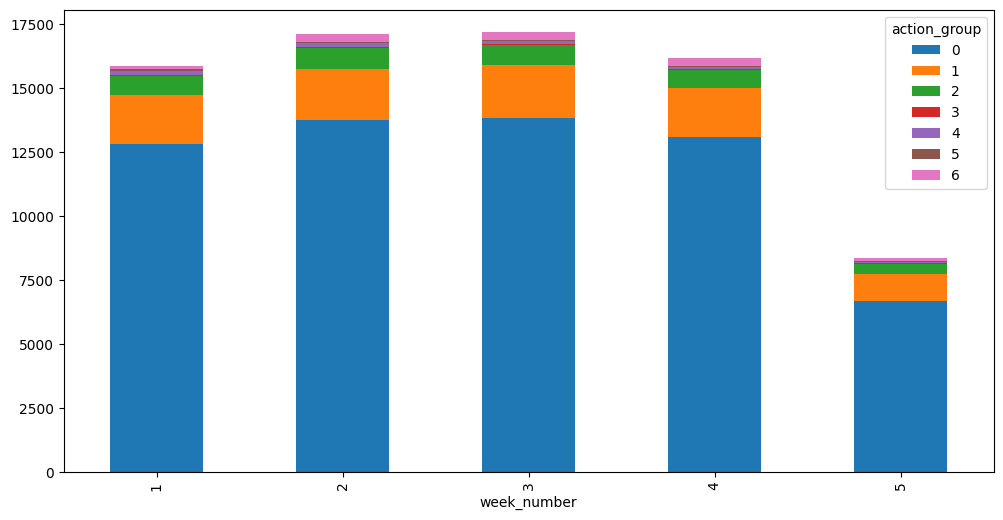

In [47]:
weekly_action_counts.plot(kind='bar', stacked=True, figsize=(12, 6))